In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
#import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data contains both the first round result and baseline data
#
# columns: 
# RBS: 20-length RBS seq
# RBS6: 6-length RBS seq, which the [7:13] positions
# variable: for first round results, denote which replication is the seq. 
# label: normalised label (zero mean and unit variance)

Path = '../../data/firstRound+Baseline.csv'

df = pd.read_csv(Path)
df.head()

,RBS,RBS6,variable,label,Group
0,TTTAAGAAGGAGATATACAT,AGGAGA,Rep1,3.162414,First round result
1,CTTAAGAAGGAGATATACAT,AGGAGA,Rep1,1.510065,First round result
2,GTTAAGAAGGAGATATACAT,AGGAGA,Rep1,0.104638,First round result
3,ATTAAGAAGGAGATATACAT,AGGAGA,Rep1,1.549313,First round result
4,TCTAAGAAGGAGATATACAT,AGGAGA,Rep1,1.673901,First round result


In [3]:
df.shape

(379, 5)

Text(0.5, 1.0, 'All label')

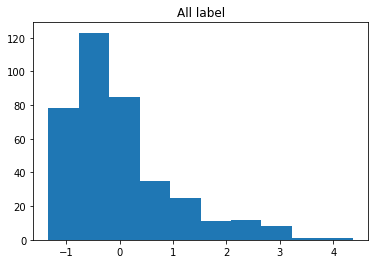

In [4]:
plt.hist(df['label'])
plt.title('All label')

(266, 5)

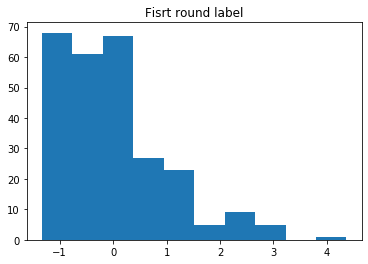

In [5]:
# extract first round result
df_FRR = df[df['Group'] == 'First round result']
plt.hist(df_FRR['label'])
plt.title('Fisrt round label')
df_FRR.shape

(113, 5)

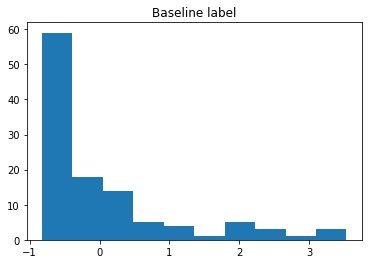

In [6]:
# extract baseline data
df_BD = df[df['Group'] == 'Baseline data']
plt.hist(df_BD['label'])
plt.title('Baseline label')
df_BD.shape

In [7]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data = np.asarray(df[['RBS', 'label']])
data_FRR = np.asarray(df_FRR[['RBS', 'label']])
data_BD = np.asarray(df_BD[['RBS', 'label']])

In [8]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# regression evaluation metric, 'NRMSE' or 'r2_score'
metric = 'NRMSE'

# string kernel list 
# kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw]
kernels = [sum_onehot_spectrum_kernel_pw]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}
embedding_name = ['onehot', 'kmer', 'label']
kernel_name = {
               spectrum_kernel_pw: 'spec',
               #sum_spectrum_kernel_pw: 'sspec',
               sum_onehot_spectrum_kernel_pw: 'sospec',
               #mixed_spectrum_kernel_pw: 'mspec',
               #WD_kernel_pw: 'WD',
               #sum_onehot_WD_kernel_pw: 'sWD',
               #WD_shift_kernel_pw: 'WDshift'
                }

train_scores = {}
test_scores = {}

data_dict = {
             'all': data,
             'First round result': data_FRR,
             'Baseline data': data_BD,
             None: None
            }

In [9]:
def run_regression(model, data_name, kernel, embedding, data_name_test = None):
    # when data_name_test is none, the regression is run on the data_name with splitting to 80/20
    # otherwise, the regression model is trained on data_name and tested on data_name_test
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data_dict[data_name], data_dict[data_name_test], embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data_dict[data_name], data_dict[data_name_test], embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag, metric = metric)
    key = data_name + '_' + str(data_name_test) + '_' + regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores[key] = train_score
    test_scores[key] = test_score
    print()

## Regression on individual groups

all

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>,
            kernel_params=None)
Train NRMSE: 0.13079057888131895
Test NRMSE: 0.14159085324705217

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.12784682144152204
Test NRMSE: 0.14433731626804827

First round result

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>,
            kernel_params=None)
Train NRMSE: 0.10238344221916619
Test NRMSE: 0.13635584214751104

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=Pairwise

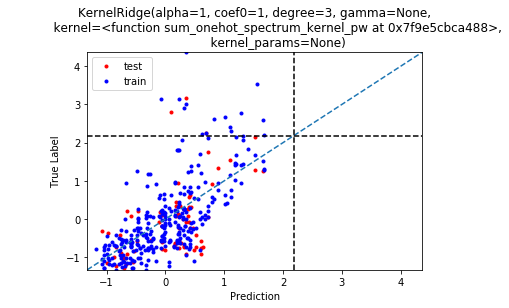

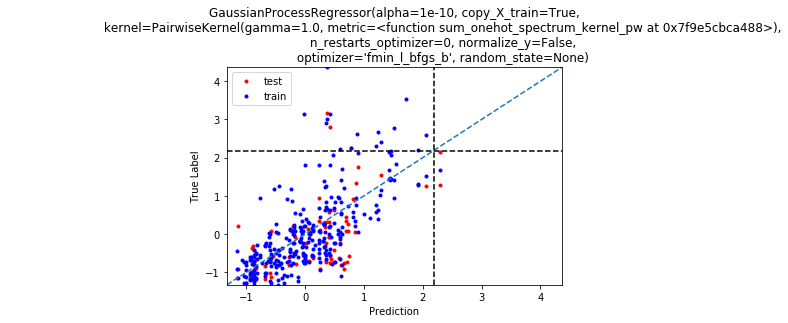

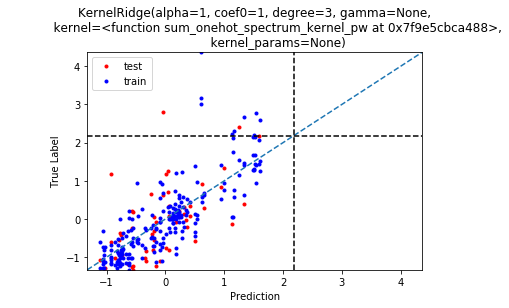

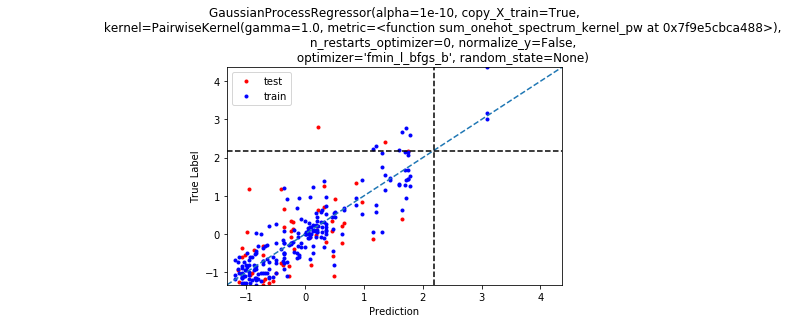

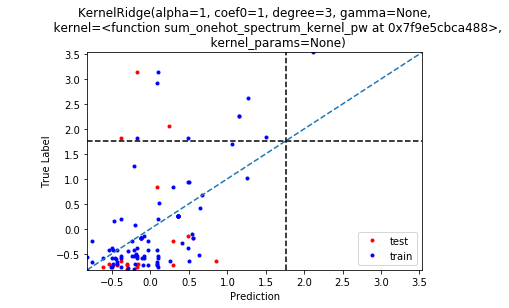

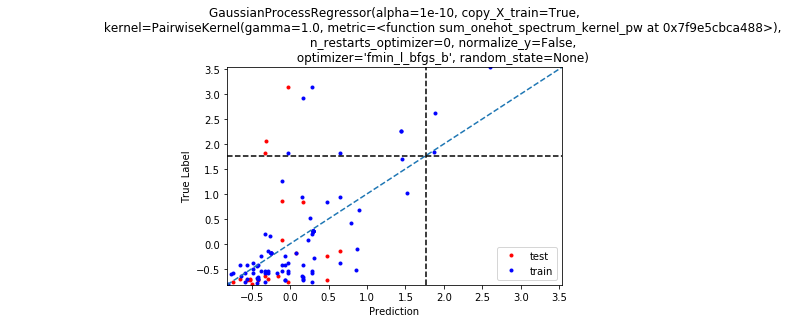

In [10]:
for data_name in data_dict.keys():
    print(data_name)
    print()
    if data_name is not None:
        for model in [KernelRidge, GaussianProcessRegressor]:
            for kernel in kernels:
                run_regression(model, data_name, kernel, 'label')

## Regression with training on (First Round Results)FRR and testing on (Baseline)BL

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>,
            kernel_params=None)
Train NRMSE: 0.11402171835406487
Test NRMSE: 0.4221459649717759

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.09530833104406229
Test NRMSE: 4.1038370743641845



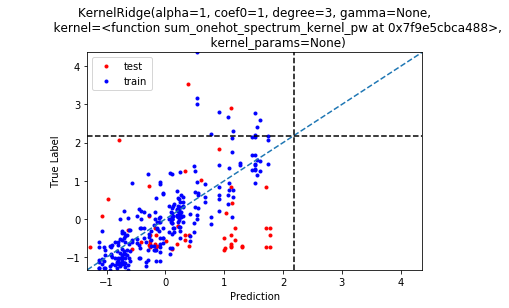

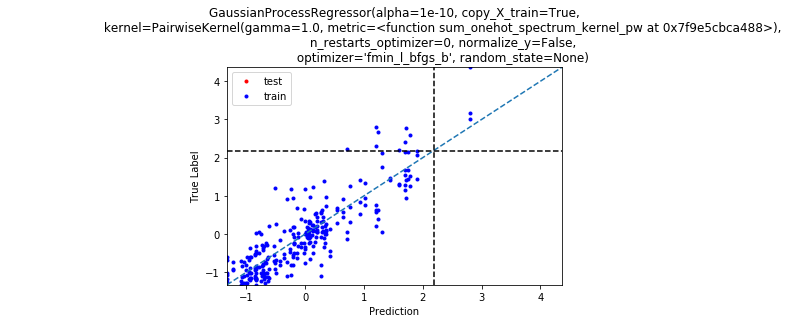

In [11]:
for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, 'First round result', kernel, 'label', 'Baseline data')

In [12]:
## Regression with training on (Baseline)BL and testing on (First Round Results)FRR

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>,
            kernel_params=None)
Train NRMSE: 0.1631624797657311
Test NRMSE: 0.20536044607284773

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function sum_onehot_spectrum_kernel_pw at 0x7f9e5cbca488>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train NRMSE: 0.1525456591307972
Test NRMSE: 0.4250159418936738



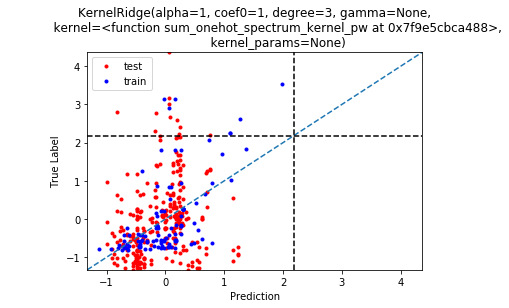

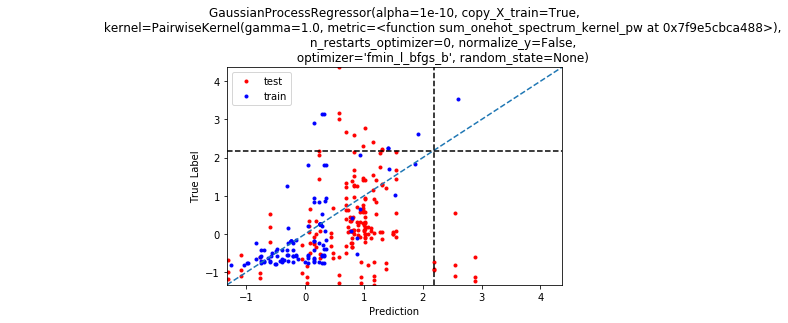

In [13]:
for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, 'Baseline data', kernel, 'label', 'First round result')

## Compare

Text(0.5, 1.0, 'Test Scores')

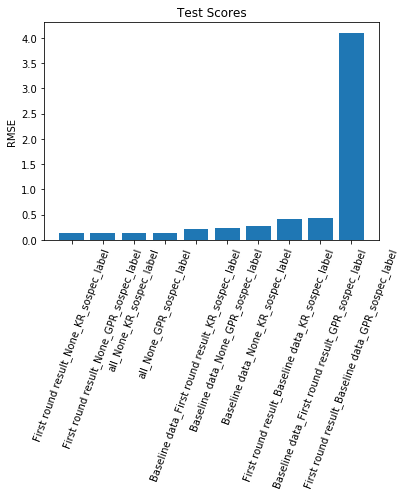

In [14]:
sorted_test_scores = sorted(test_scores.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')